## Notebook Objectives

Summarize the Necessary Knowleadge to Apply Clustering Models in Businesses


### About the Models

&emsp;&emsp;_How It Works_    
&emsp;&emsp;_When to Use it_    
&emsp;&emsp;_Advantages_    
&emsp;&emsp;_Disadvantages_    
&emsp;&emsp;_Statistical Assumptions_    
&emsp;&emsp;_Parameters_    
&emsp;&emsp;_More Explanations_


### Agenda

[Business Questions](#Business-Questions)<br>

[Imports](#Imports)<br>
&emsp;[Functions](#Functions)<br>
&emsp;[Settings](#Settings)<br>

[Loading Data](#Loading-Data)<br>

[Feature Engineering](#Feature-Engineering)<br>

[Preprocessing](#Preprocessing)<br>
&emsp;[Handling Missing Values](#Handling-Missing-Values)<br>
&emsp;[Encoding Categorical Variables](#Encoding-Categorical-Variables)<br>
&emsp;[Scaling/Normalizing Features](#Scaling/Normalizing-Features)<br>
&emsp;[Handling Outliers](#Handling-Outliers)<br>

[Feature Selection](#Feature-Selection)<br>

[Models](#Models)<br>
&emsp;[Choosing The Right Clustering Algorithm](#Choosing-The-Right-Clustering-Algorithm)<br>
&emsp;[DBSCAN](#DBSCAN)<br>

[Evaluation Metrics](#Evaluation-Metrics)<br>
&emsp;[Choosing the Right Metric](#Choosing-the-Right-Metric)<br>

[Feature Importances](#Feature-Importances)<br>

[Cluster Analysis](#Cluster-Analysis)<br>
&emsp;[Clusters Distances](#Clusters-Distances)<br>
&emsp;[Clusters Behaviors](#Clusters-Behaviors)<br>
&emsp;[In Depth Analysis](#In-Depth-Analysis)<br>

[Cluster Profiles](#Cluster-Profiles)<br>
&emsp;&emsp;[Business Opportunity Map](#Customer-Profiles/Business-Opportunity-Map)<br>
&emsp;&emsp;[Business Descriptions](#Business-Descriptions)<br>

## Business Questions

## Imports

In [71]:
import psutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # Ensure you import Axes3D
import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import pdist, cdist

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report



import warnings
warnings.filterwarnings("ignore")


### Functions

In [72]:
def check_memory_usage():
    # Get memory usage in bytes
    memory = psutil.virtual_memory()

    # Total physical memory available
    total_memory = memory.total

    # Available physical memory
    available_memory = memory.available

    # Used physical memory
    used_memory = memory.used

    # Percentage of used memory
    memory_percent = memory.percent

    print(f"Total Memory: {total_memory} bytes")
    print(f"Available Memory: {available_memory} bytes")
    print(f"Used Memory: {used_memory} bytes")
    print(f"Memory Usage Percentage: {memory_percent}%")
check_memory_usage()

def plot_cluster_boxplots(data, cluster_col, variable_a, variable_b, showfliers=False, horizontal_line_at=0):
    """
    Plot boxplots for sales and profit by cluster.

    Parameters:
    - data: DataFrame containing the dataset.
    - cluster_col: The name of the column representing cluster labels.
    - variable_a: The name of the column representing variable_a
    - variable_b: The name of the column representing variable_b
    """
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    sns.boxplot(x=cluster_col, y=variable_a, data=data, showfliers=showfliers)
    plt.title(f'{variable_a} by {cluster_col}')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=cluster_col, y=variable_b, data=data, showfliers=showfliers)
    plt.title(f'{variable_b} by {cluster_col}')
    
    plt.axhline(horizontal_line_at, color='r')

    plt.tight_layout()
    plt.show()


def plot_cluster_analysis(data, cluster_col, variable_a, variable_b, palette='mako'):
    """
    Plot countplot for clusters and scatterplot for recency vs frequency by cluster.

    Parameters:
    - data: DataFrame containing the dataset.
    - cluster_col: The name of the column representing cluster labels.
    - variable_a: The name of the column representing variable_a.
    - variable_b: The name of the column representing variable_b.
    - palette: Color palette for the plots (default is 'mako').
    """
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    sns.countplot(x=cluster_col, data=data, palette=palette)
    plt.title(f'Count of {cluster_col} Clusters')

    plt.subplot(1, 2, 2)
    sns.scatterplot(data=data, x=variable_a, y=variable_b, hue=cluster_col, palette=palette)
    plt.title(f'{variable_a} vs {variable_b} by {cluster_col}')

    plt.tight_layout()
    plt.show()

Total Memory: 16849256448 bytes
Available Memory: 5136367616 bytes
Used Memory: 11712888832 bytes
Memory Usage Percentage: 69.5%


### Settings

In [73]:
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: '%.2f' % x)

### Loading Data

In [ ]:
# https://www.kaggle.com/datasets/jr2ngb/superstore-data
df_customer_abt = pd.read_parquet("../data/df_customer_abt.parquet")
print(df_customer_abt.shape)
df_customer_abt.head(2)

(51290, 24)


Row ID       Order ID Order Date Ship Date       Ship Mode Customer ID  \
0   42433   AG-2011-2040   1/1/2011  6/1/2011  Standard Class    TB-11280   
1   22253  IN-2011-47883   1/1/2011  8/1/2011  Standard Class    JH-15985   

     Customer Name   Segment         City            State    Country  \
0  Toby Braunhardt  Consumer  Constantine      Constantine    Algeria   
1      Joseph Holt  Consumer  Wagga Wagga  New South Wales  Australia   

   Postal Code  Market   Region        Product ID         Category  \
0          NaN  Africa   Africa  OFF-TEN-10000025  Office Supplies   
1          NaN    APAC  Oceania   OFF-SU-10000618  Office Supplies   

  Sub-Category              Product Name  Sales  Quantity  Discount  Profit  \
0      Storage       Tenex Lockers, Blue 408.30         2      0.00  106.14   
1     Supplies  Acme Trimmer, High Speed 120.37         3      0.10   36.04   

   Shipping Cost Order Priority  
0          35.46         Medium  
1           9.72         Medium

## Preprocessing

### Handling Missing Values

In [76]:
print(f"Original Shape: {df_customer_abt.shape}")
df_customer_abt = df_customer_abt.dropna()
print(f"After Dropna Shape: {df_customer_abt.shape}")

Original Shape: (1590, 15)
After Dropna Shape: (1583, 15)


### Handling Outliers

In [77]:
# outliers_to_remove = ['column_a', 'column_b']

# for feature in outliers_to_remove:
#     percentile_lim = df_customer_abt[feature].quantile(0.99)
#     df_customer_abt = df_customer_abt[df_customer_abt[feature] <= percentile_lim]

### Encoding Categorical Variables

## Feature Selection

In [78]:
features = (
    df_customer_abt.select_dtypes('number')
                    # .drop(columns=['Customer ID'])
                    .columns
                    .to_list()
)

# features = ['avg_ticket', 'avg_produtcs_per_purchase', 'avg_discount', 'avg_profit', 'avg_shipping_cost']

categories = df_customer_abt.select_dtypes(object).columns
df_customer_abt[features].head(2)

total_sales  avg_ticket  total_products  avg_produtcs_per_purchase  \
0     13747.41      327.32             145                       3.45   
1      5884.20      140.10             139                       3.31   

   median_discount  avg_discount  std_discount  total_profit  avg_profit  \
0             0.00          0.10          0.16        447.69       10.66   
1             0.00          0.17          0.22        677.48       16.13   

   total_shipping_cost  avg_shipping_cost  
0              1236.15              29.43  
1               903.92              21.52

### Scaling/Normalizing Features

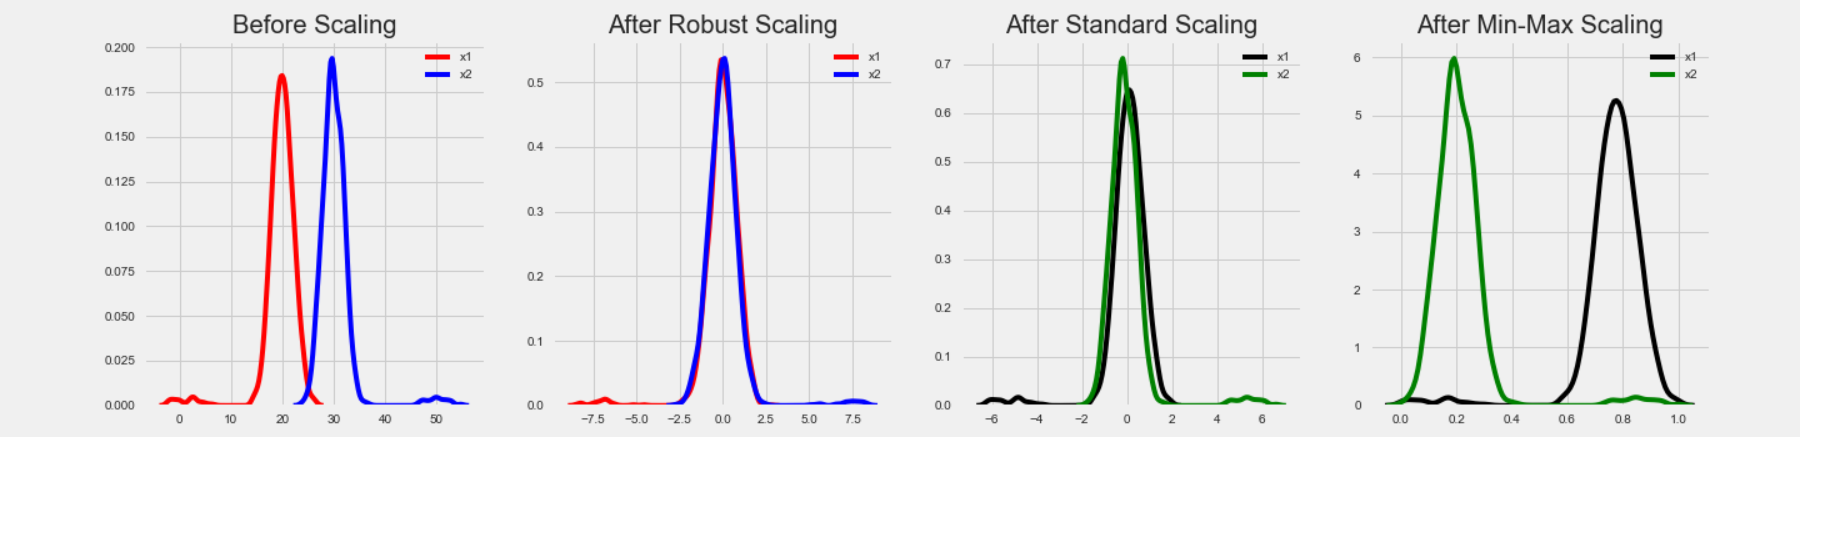

In [81]:
# scaler = MinMaxScaler()
# df_customer_abt_scaled = pd.DataFrame(scaler.fit_transform(df_customer_abt[features]), columns=features)

# df_customer_abt_scaled = pd.DataFrame(normalize(df_customer_abt[features]), columns=features)


## Models

### Choosing The Right Clustering Algorithm

Choosing The Right Clustering Algorithm involves factors as

        Shape and Distribution.
        Dataset size.
        Noise and outliers.
        Dimensionality.

Performing an [Exploratory Data Analysis](https://github.com/pauloreis-ds/machine-learning-essentials/tree/main/clustering/p01v01_eda.ipynb) is essential to understand the structure and distribution of the data before applying clustering algorithms.

### DBSCAN


**How It Works:** StatQuest: Clustering with DBSCAN, Clearly Explained!!! (https://www.youtube.com/watch?v=RDZUdRSDOok&t)



- **When to Use it:**

    It's useful when you expect all clusters to have a similar density.    
    DBSCAN assumes that clusters are areas of high density separated by areas of low density.    

    Non-linear and Arbitrary Shaped Clusters: DBSCAN excels at finding clusters of arbitrary shapes (unlike k-means, which assumes spherical clusters). It's suitable for datasets where clusters are non-linear or irregularly distributed.



- **Advantages**

    It Handles noise effectively: DBSCAN identifies soutliers that do not belong to any cluster, making it ideal for noisy datasets (anomaly detection).    
    It helps isolate and analyze outliers without distorting cluster formation.    

    Non-Parametric Nature: it doesn’t assume specific data distributions, so it can identify Arbitrarily Shaped Clusters.    
    Suitable for complex datasets where clusters are non-linear or irregular.    

    Handling Clusters of Varying Sizes: DBSCAN can detect clusters of different sizes and densities (provided they are reasonably uniform in density).    

    No need to specify the number of clusters: automatically determines the number of clusters based on the density of the data.    

    Interpretation: parameters (eps and min_samples) have intuitive meanings: neighborhood size and minimum points for forming a cluster.



- **Disadvantages**


    Clusters with Varying Densities: Struggles when clusters have widely different densities.    
    If for one group the points are about five units away from one another, and the other group is one unit away... depending on the distance between these two clusters, it might be difficult to determine the differentiation between them.    
    
    If the points are very close together and the eps parameter can not be estimated correctly.    

    High Dimensionality: performance may degrade as dimensionality increases due to the curse of dimensionality.    

    Parameter Sensitivity: choosing the right values for eps (neighborhood radius) and min_samples (minimum points in a neighborhood) is crucial and often requires domain knowledge or experimentation.    

    Sensitivity to Scale: in theory DBSCAN is not sensitive to scale because it focuses on density (number of points within a specified neighborhood) rather than explicit distances. However, the eps parameter, which defines the radius of the neighborhood, can be influenced by the scale of the features (since it relies on a distance metric).    

    Misclassification of sparse clusters: points labeled as noise may sometimes belong to meaningful but sparse clusters (inability to Handle Non-Convex Noise).    

    Computationally expensive for large datasets.



- **Statistical Assumptions**

    Density-Based Assumption: clusters are areas of high density separated by areas of low density.    

    Noise Assumption: some points in the dataset do not belong to any cluster (outliers or noise)
    

- **Parameters**

    eps (ε): epsilon defines the maximum distance between two points for them to be considered as part of the same neighorhood.    

        Smaller epsilon results in smaller, more compact and dense clusters, potentially resulting in more clusters being formed, as well as more points being labeled as noise, as the model becomes less tolerant to point that are not densely surrounded by other points.

        Larger epsilon expands the neighborhood size. Outliers may now become part of a cluster. 
        It leads to fewer clusters being formed since it may merge clusters or include noise points into clusters.
    

    min_samples speficifies the minimum number of points required to form a dense region (core point) in order for it to be considered a cluster.    

        If there are fewer than min_sample points within the eps neighborhood of a point, that point is considered an outlier (noise) rather than part of a cluster.

        Smaller min_samples can lead to the formation of more clusters, since it allows for more points to be considered as core points (this can also result in larger clusters).

        Larger min_samples values lead to more conservative clustering, as the model requires more points to agree the core status of a point.
        I may lead to smaller clusters, as the algorithm becomes less likely to form clusters around sparse regions of the dataset.

        Rule of Thumb: Typically set to a value slightly larger than the number of dimensions in the dataset (e.g., min_samples = dimensions + 1), but it depends on the dataset's characteristics.


- **More Explanations**

    How to Know the density of the data?    
    Clusters are formed based on the density of points in a region, not their distance to a centroid.   
    So, you need to measure how data points are distributed within a space.

        1. Nearest Neighbor Method: calculate the average distance to the k neighbors for each data point. Low average distances indicate higher density.

        2. Local Density Estimation: Employ density estimation techniques such as kernel density estimation (KDE) to estimate the densit of the data points within different regions of your dataset. AKK sns.pairplot(data, diag_kind='kde')

        DBSCAN Parameter with Python: https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd 


| min_samples | epsilon    | Clustering Behavior                               | Expected Outcome                           |
|--------|------|---------------------------------------------------|---------------------------------------|
| High   | High | Large, dense clusters; more noise                 | Fewer, well-separated clusters        |
| High   | Low  | Very few clusters; mostly noise                   | Overly strict, potential underclustering |
| Low    | High | Loose clusters, risk of merging or overclustering | Larger, less defined clusters         |
| Low    | Low  | Small, tight clusters; fragmented results         | Fine-grained clusters, reduced noise  |

<br>

<br>

| min_samples | epsilon    | When to Use                                                                                                                      |
|--------|------|----------------------------------------------------------------------------------------------------------------------------------|
| High   | High | - When your dataset has well-separated, dense clusters.                                                                          <br> - You want to focus on robust clusters and are okay with more noise.                                                                            <br> - Use in situations where the clusters are large and compact, such as geographical data or tightly packed sensor measurements. |
| High   | Low  | - When you expect very tight, highly dense clusters and are okay with many points being classified as noise.                      <br> - Use for datasets where clusters are very small and tightly packed, like micro-scale biological data.                                            <br> - Typically results in underclustering and is rarely the best choice.                                                                                      |
| Low    | High | - When you have loosely defined, overlapping clusters or varying densities in your data.                                         <br> - Use for datasets where broadly connected regions should be grouped together (e.g., social networks or customer segmentation).                            <br> - Be cautious of overclustering or merging distinct clusters.                                                                                            |
| Low    | Low  | - When you want to detect small, fine-grained structures or focus on capturing tiny clusters.                                    <br> - Useful for high-resolution data where individual subgroups must be isolated (e.g., identifying anomalies or granular market segments).                     <br> - May lead to fragmented clusters.                                                                                                                       |


    

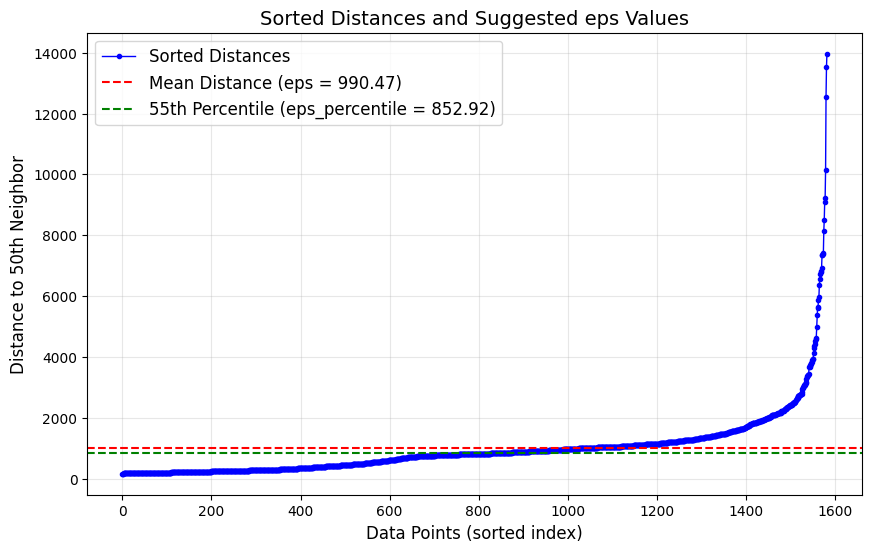

CPU times: total: 46.9 ms
Wall time: 171 ms


In [16]:
%%time
n_neighbors = 50
knn = NearestNeighbors(n_neighbors=50, metric='euclidean')
knn.fit(df_customer_abt[features])
distances, indices = knn.kneighbors(df_customer_abt[features])

distances = np.sort(distances[:, n_neighbors-1])
distances = pd.DataFrame(distances)
eps = distances.mean()[0]
percentail = 0.55
eps_percentile = distances.quantile(percentail)[0]

plt.figure(figsize=(10, 6))
plt.plot(distances, label='Sorted Distances', color='blue', marker='o', linewidth=1, markersize=3)

# Plot the mean and median as horizontal lines
plt.axhline(y=eps, color='red', linestyle='--', label=f'Mean Distance (eps = {eps:.2f})')
plt.axhline(y=eps_percentile, color='green', linestyle='--', label=f'{round(percentail*100)}th Percentile (eps_percentile = {eps_percentile:.2f})')

# Add titles and labels
plt.title('Sorted Distances and Suggested eps Values', fontsize=14)
plt.xlabel('Data Points (sorted index)', fontsize=12)
plt.ylabel(f'Distance to {n_neighbors}th Neighbor', fontsize=12)

# Add legend
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()


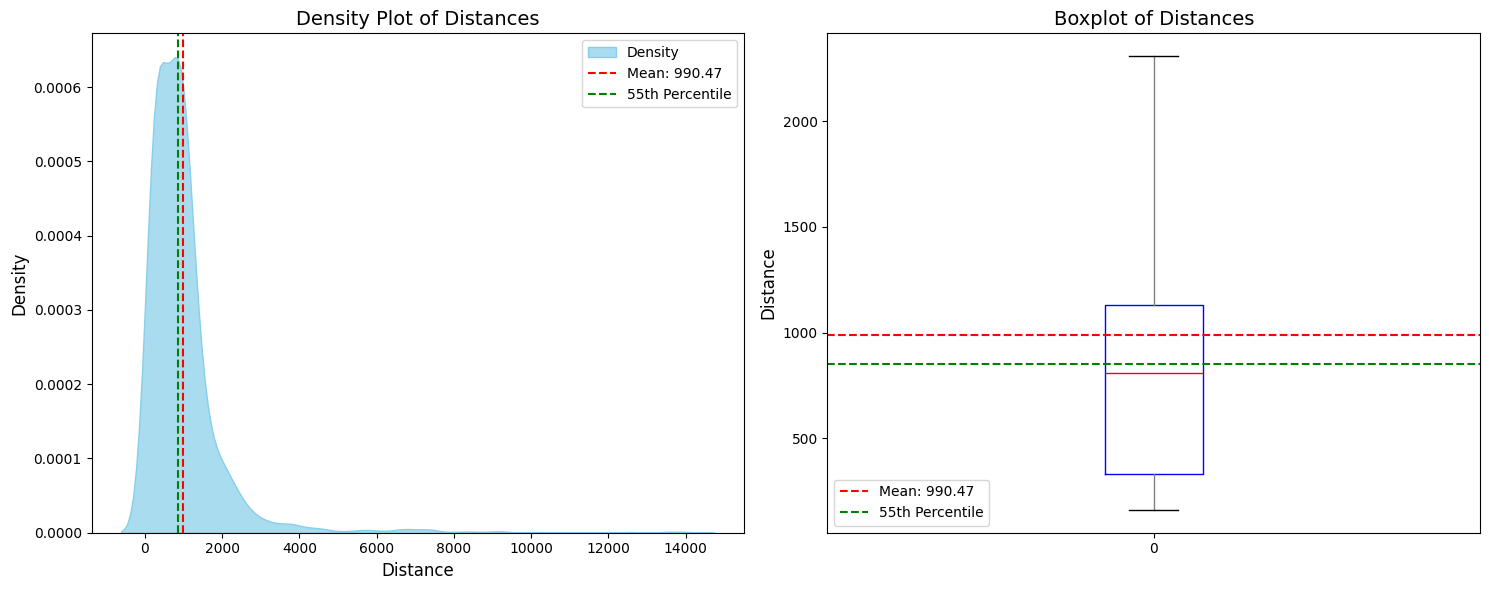

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Density plot
sns.kdeplot(
    distances[0], 
    ax=axes[0], 
    fill=True, 
    color='skyblue', 
    alpha=0.7, 
    label='Density'
)
axes[0].axvline(x=eps, color='red', linestyle='--', label=f'Mean: {eps:.2f}')
axes[0].axvline(x=eps_percentile, color='green', linestyle='--', label=f"{round(percentail*100)}th Percentile")
axes[0].set_title('Density Plot of Distances', fontsize=14)
axes[0].set_xlabel('Distance', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].legend(fontsize=10)

# Boxplot
distances.plot.box(
    ax=axes[1], 
    showfliers=False, 
    color=dict(boxes='blue', whiskers='gray', medians='red', caps='black')
)
axes[1].axhline(y=eps, color='red', linestyle='--', label=f'Mean: {eps:.2f}')
axes[1].axhline(y=eps_percentile, color='green', linestyle='--', label=f"{round(percentail*100)}th Percentile")
axes[1].set_title('Boxplot of Distances', fontsize=14)
axes[1].set_ylabel('Distance', fontsize=12)
axes[1].legend(fontsize=10, loc='lower left')

plt.tight_layout()
plt.show()


In [18]:
distances.describe().T

count   mean     std    min    25%    50%     75%      max
0 1583.00 990.47 1129.29 160.39 333.13 809.46 1130.10 13966.52

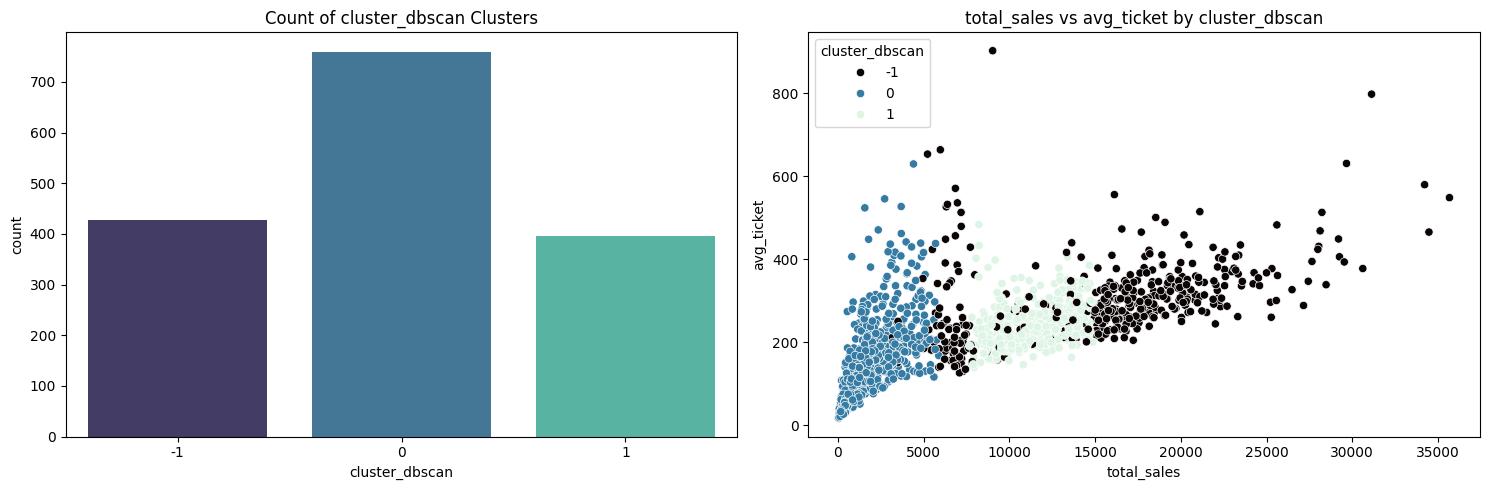

CPU times: total: 78.1 ms
Wall time: 371 ms


In [19]:
%%time
dbscan = DBSCAN(eps=eps_percentile, min_samples=n_neighbors, metric='euclidean')
df_customer_abt['cluster_dbscan'] = dbscan.fit_predict(df_customer_abt[features])

plot_cluster_analysis(df_customer_abt, 'cluster_dbscan', 'total_sales', 'avg_ticket', palette='mako')

## Evaluation Metrics

# Clustering Evaluation Metrics

### 1. **Silhouette Score**

Measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation).    

It ranges from 1 (well-clustered) to -1 (misclassified)

**Advantages:**
- interpretable Results.
- It measures both how tightly points are grouped within clusters and how well-separated clusters are.

**Limitations:**
- Sensitive to noise and outliers.
- Scalability: computationally expensive (due to pairwise distances).

**Formula**: 

For a data point \( i \):

$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$


Where:
- a(i): Average distance from (i) to all other points in the same cluster.
- b(i): Average distance from (i) to all points in the nearest cluster.



---

### 2. **Dunn Index**
Measures the ratio of the minimum inter-cluster (between different clusters) distance to the maximum intra-cluster (within the cluster) distance.

Higher Values indicates better clustering.

**Advantages:**
- Compactness and Separation: it combines intra-cluster compactness and inter-cluster separation.
- Encourages Well-Separated Clusters: higher values indicate clusters are both compact and well-separated.

**Limitations:**
- Sensitive to noise and outliers: they can distort inter-cluster distances.
- Not Widely implemented in libraries.


**Formula**:
$$
\text{Dunn Index} = \frac{\min(\text{inter-cluster distances})}{\max(\text{intra-cluster distances})}
$$

---

### 3. **Davies-Bouldin Index**

Measures the average similarity ratio of each cluster with the cluster that is most similar to it.

Lower Values indicate better clustering.

**Advantages:**
- Accounts for intra-cluster compactness and inter-cluster separation.
- Computationally efficient.

**Limitations:**
- Sensitive to cluster size variations.


**Formula**:
$$
DB = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \frac{\sigma_i + \sigma_j}{d_{ij}}
$$


  Where:
  - k is the number of clusters
  - sigma i: Average distance of all points in cluster \( i \) to the centroid of cluster \( i \) (intra-cluster scatter).
  - sigma j: Average distance of all points in cluster \( j \) to the centroid of cluster \( j \) (intra-cluster scatter).
  - d ij: Distance between centroids of clusters \( i \) and \( j \) (inter-cluster distance).


---

### 4. **Calinski-Harabasz Index (Variance Ratio Criterion)**

Measures the ratio of the sum of between-cluster dispersion to within-cluster dispersion.

In other words, ratio of the variance between clusters to the variance within clusters.

It is particularly useful for determining the optimal number of clusters in a dataset.

Higher Values indicate better-defined clusters. This means clusters are well-separated and points within each clusters are compact.

**Advantages:**
- Computationally Efficient.
- Scale-Invariant: it is not affected by the scale of the data, as it relies on the ratio of between-cluster dispersion and within-cluster dispersion.

**Limitations:**
- Sensitive to noise and outliers: they can significantly affect the within-cluster dispertion (SSW), leading to misleading values of the index.
- Sensitive to the number of clusters: it can favor larger number of clusters, especially in cases where the dara has a high-dimensional space or outliers.


**Formula**:
$$
CH = \frac{\text{Tr}(B_k)}{\text{Tr}(W_k)} \cdot \frac{n - k}{k - 1}
$$
  Where:
  - \( \text{Tr}(B_k) \): Trace of between-cluster dispersion matrix.
  - \( \text{Tr}(W_k) \): Trace of within-cluster dispersion matrix.
  - \( n \): Number of data points.
  - \( k \): Number of clusters.

<br>

<br>


**More Explanations**

Balancing Compactness and Separation applies to both Dunn Index and Davies-Bouldin Index. However, there are differences in how they achieve this.

Dunn Index uses extreme values (smallest inter-cluster distance, largest intra-cluster distance) to assess the worst-case scenario for clustering quality and is sensitive to noise and outliers.

Davies-Bouldin Index averages dispersion and separation over all clusters, making it less sensitive to individual clusters but more prone to favoring spherical shapes (due to its reliance on metrics that assume compactness around centroid).

Dunn Index is explicity designed to measure both compactness (intra-cluster distance) and separation (inter-cluster distance).

        It uses the smallest inter-cluster distance to represent separation
        and largest intra-cluster distance to represent compactness.

Davies-Bouldin Index balances compactness and separation indirectly.

        It uses the distance between clusters centroids to represent separation
        and intra-cluster Dispersion to represent compactness.

In [94]:
%%time
print(f"Silhouette Score: {round(silhouette_score(df_customer_abt[features], df_customer_abt['cluster']), 2)}")

print(f"Davies-Bouldin Index: {round(davies_bouldin_score(df_customer_abt[features], df_customer_abt['cluster']), 2)}")

print(f"Calinski-Harabasz Index: {round(calinski_harabasz_score(df_customer_abt[features], df_customer_abt['cluster']), 2)}")

print("Dunn Index: TO DO")


Silhouette Score: 0.6
Davies-Bouldin Index: 0.61
Calinski-Harabasz Index: 5647.72
Dunn Index: TO DO
CPU times: total: 15.6 ms
Wall time: 47.1 ms


### Choosing the Right Metric


Silhouette Score, Dunn Index, Davies-Bouldin Index and Calinski-Harabasz Index (Variance Ratio Criterion) generally assume that clusters are convex.

| Metric                 | Best For                                                                 | If You Need                                                                              |
|------------------------|-------------------------------------------------------------------------|-----------------------------------------------------------------------------------------|
| Silhouette Score       | Comparing cluster configurations; general-purpose use.                 | A metric that balances cohesion and separation, and is easy to interpret.               |
| Dunn Index             | Strictly penalizing poor separation and compactness; sensitive datasets.| A stricter assessment of cluster separation and compactness.                            |
| Davies-Bouldin Index   | Quick evaluation of clustering quality; spherical clusters.            | A computationally efficient method for evaluating clustering quality.                   |
| Calinski-Harabasz Index| Determining the optimal number of clusters; variance-based clustering methods. | A metric that works well for variance-based, balanced, and well-separated clusters.      |



_Many classical metrics (e.g., Silhouette, Davies-Bouldin) can be adapted for non-Euclidean distances or density-based clustering so that they can evaluate non-convex clusters._


## Feature Importances

In [25]:
cluster_col = 'cluster'
X_train, X_test, y_train, y_test = train_test_split(df_customer_abt[features], df_customer_abt[cluster_col], test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=5,random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       104
           1       1.00      0.99      0.99       227
           2       0.97      0.99      0.98       108
           3       1.00      1.00      1.00        36

    accuracy                           0.99       475
   macro avg       0.99      0.99      0.99       475
weighted avg       0.99      0.99      0.99       475



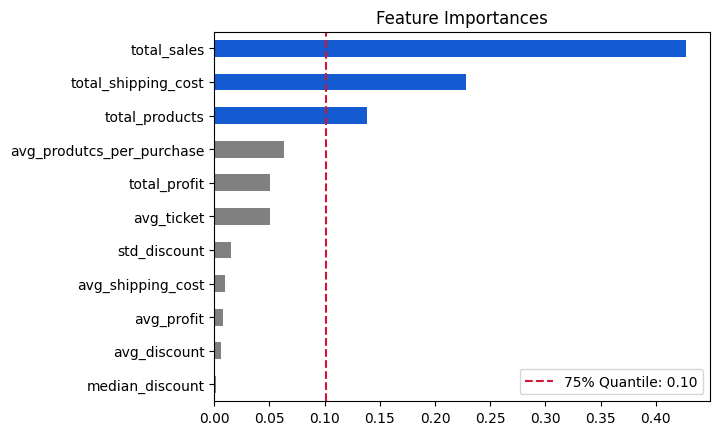

In [26]:
feature_importances = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=True)

# Define the quantile threshold
x_quantile = 0.75
threshold = feature_importances.quantile(x_quantile)
colors = ['grey' if importance < threshold else '#145ad0' for importance in feature_importances]

feature_importances.plot.barh(color=colors
                            #   , figsize=(10, 6)
                              )
plt.axvline(threshold, c='#d01433', linestyle='--', label=f'{round(x_quantile*100)}% Quantile: {threshold:.2f}')
plt.legend()
plt.title("Feature Importances")
plt.show()

## Cluster Analysis

You can also try exploring more with heatmaps

In [27]:
analysis_cols = df_customer_abt.select_dtypes('number').drop(columns=['clsuter']).columns

[]

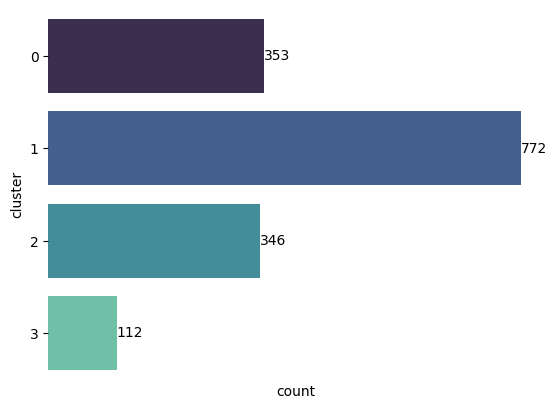

In [28]:
ax = sns.countplot(y=cluster_col, data=df_customer_abt, palette='mako')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10)
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True)
ax.set_xticks([])

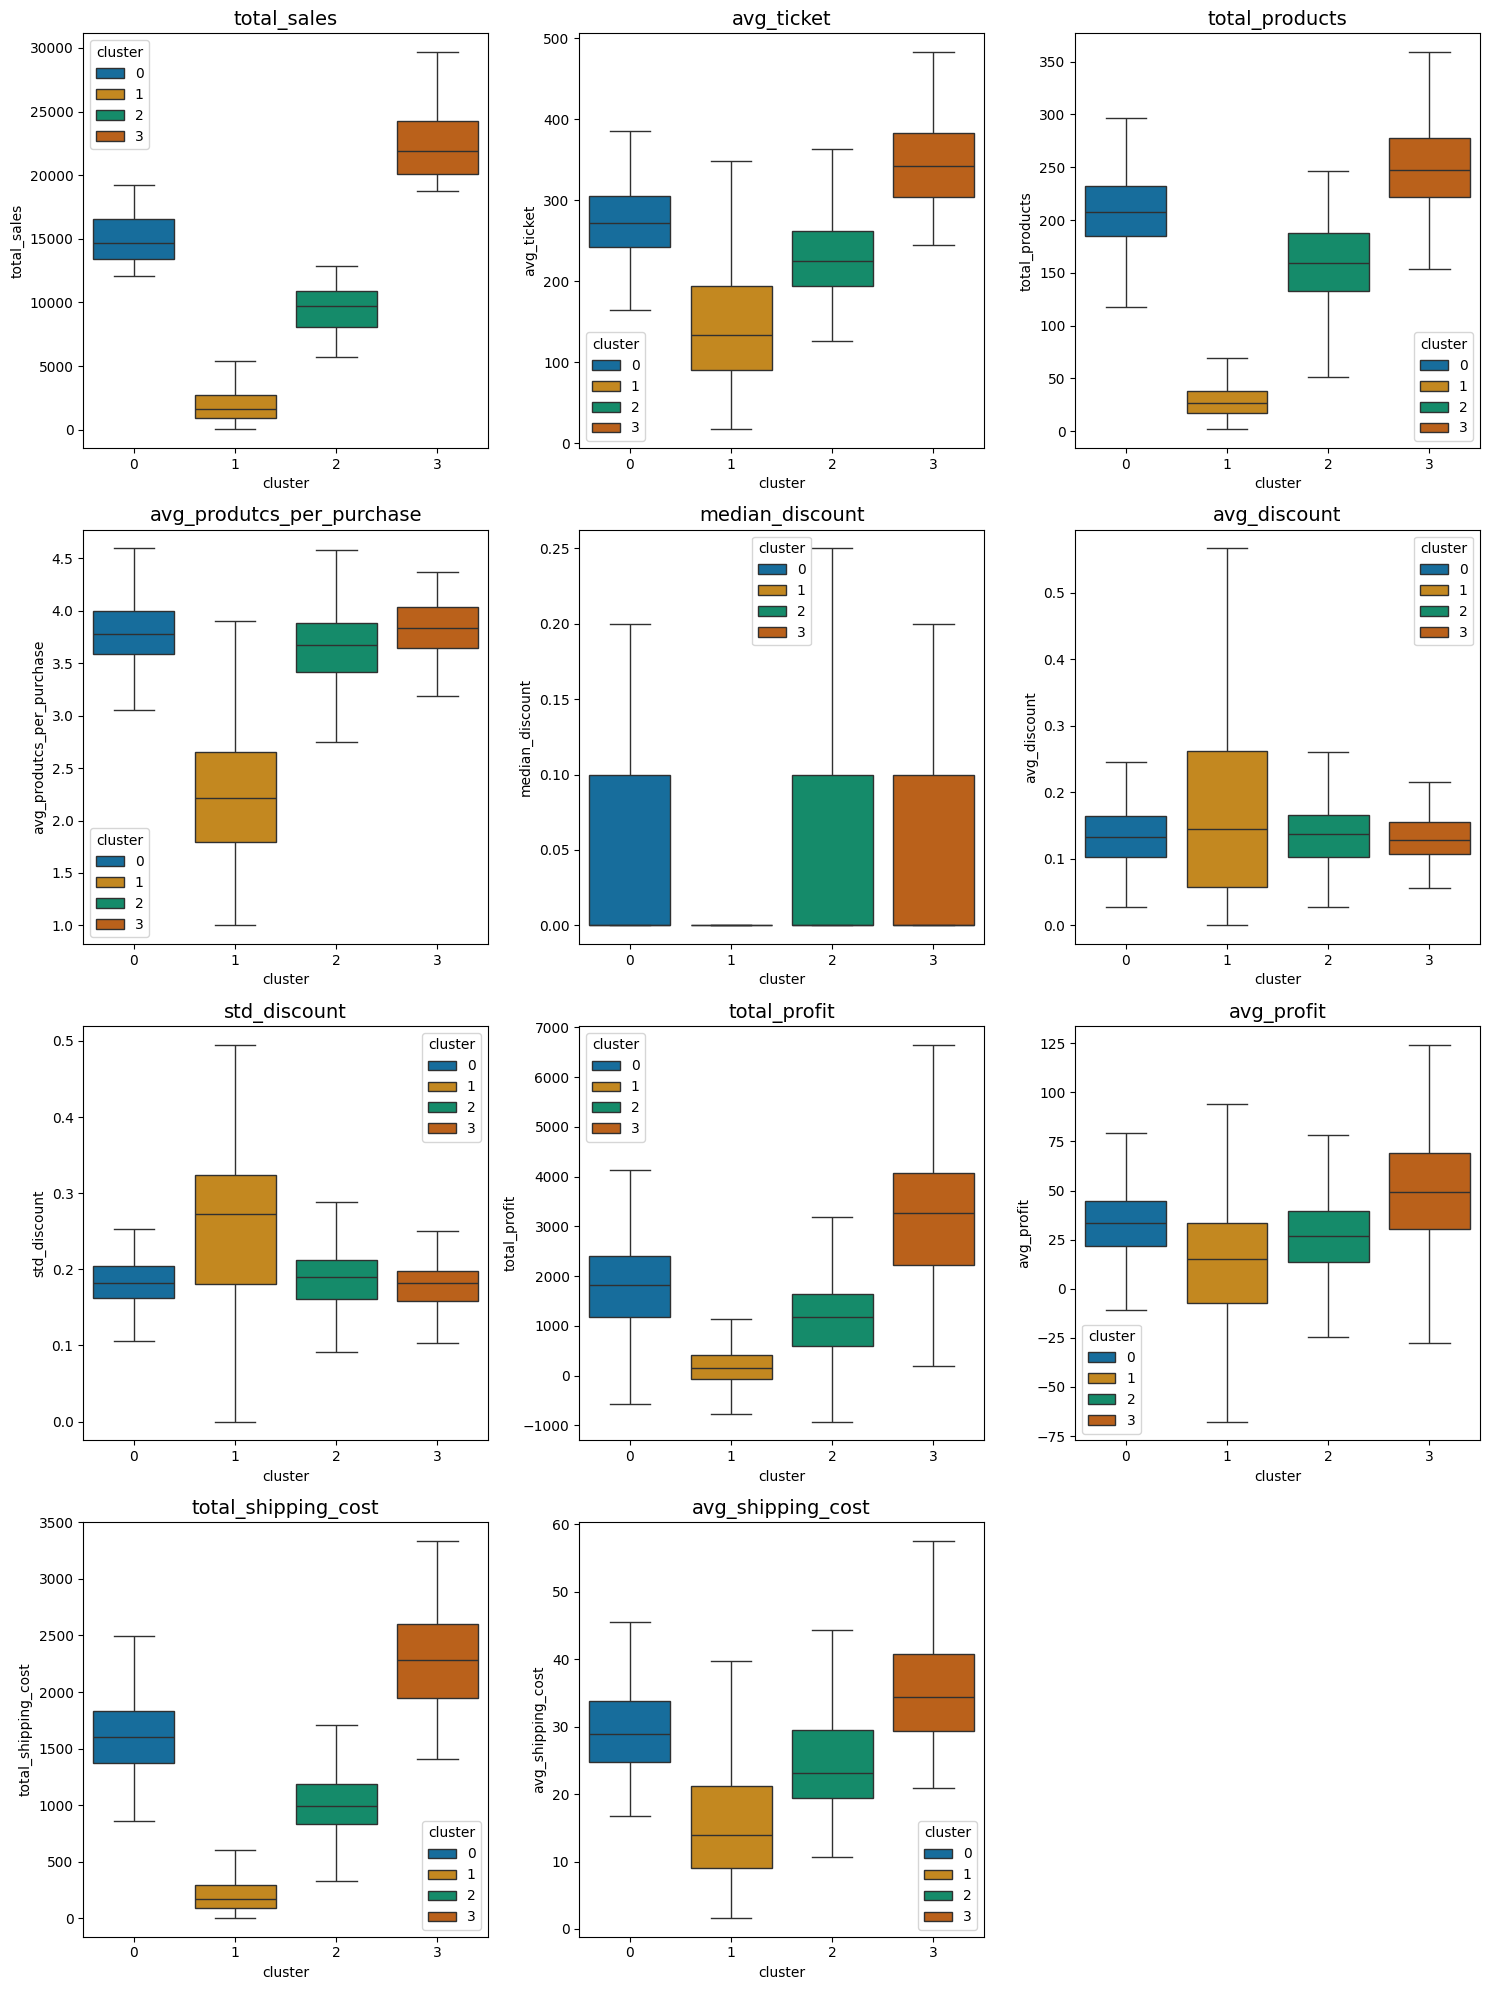

CPU times: total: 562 ms
Wall time: 2.1 s


In [38]:
%%time

"""Cluster Diff"""
# Set up the plotting area for individual subplots
num_columns = 3
num_features = len(features)
num_rows = (num_features + num_columns - 1) // num_columns

plt.figure(figsize=(15, num_rows * 5))

for i, feature in enumerate(features):
    plt.subplot(num_rows, num_columns, i + 1)
    sns.boxplot(data=df_customer_abt, x='cluster', y=feature, showfliers=False, hue='cluster', palette='colorblind')
    plt.title(f"{feature}", fontsize=14)

plt.tight_layout()
plt.show()

### Cluster Distances

In [45]:
# Ensure 'cluster' is treated as categorical
df_customer_abt[cluster_col] = df_customer_abt[cluster_col].astype(str)

# Initialize lists to store the results
within_cluster_distances = []
between_cluster_distances = []

# Loop through each cluster to calculate within-cluster distances
for cluster in df_customer_abt[cluster_col].unique():
    # Filter the data for the current cluster
    cluster_data = df_customer_abt[df_customer_abt[cluster_col] == cluster]#.sample(df_customer_abt.groupby('cluster')['cluster'].count().min())
    
    # Select the relevant features for distance calculation
    df_features = cluster_data[features].values
    
    # Calculate pairwise Euclidean distances within the cluster
    dist_matrix = pdist(df_features, metric='euclidean')
    
    # Compute the average and standard deviation of distances within the cluster
    avg_distance_within = np.mean(dist_matrix)
    std_distance_within = np.std(dist_matrix)
    
    within_cluster_distances.append((cluster, avg_distance_within, std_distance_within))

# Now calculate the centroids for each cluster
centroids = df_customer_abt.groupby(cluster_col)[features].mean()

# Calculate pairwise distances between centroids
centroid_distances = cdist(centroids, centroids, metric='euclidean')

# Flatten the centroid distances and compute the average and standard deviation
avg_distance_between_clusters = np.mean(centroid_distances[np.triu_indices_from(centroid_distances, k=1)])
std_distance_between_clusters = np.std(centroid_distances[np.triu_indices_from(centroid_distances, k=1)])

# Store results for within-cluster distances in a DataFrame
within_cluster_df = pd.DataFrame(within_cluster_distances, columns=['Cluster', 'Avg Distance Within', 'Std Distance Within'])

# Display the results
print("Within Cluster Distances:")
print(within_cluster_df)

# Display the average and standard deviation of distances between clusters
print(f"\nAverage Distance Between Clusters: {avg_distance_between_clusters:.2f}")
print(f"Standard Deviation of Distance Between Clusters: {std_distance_between_clusters:.2f}")


Within Cluster Distances:
  Cluster  Avg Distance Within  Std Distance Within
0       0              2775.03              1520.01
1       2              2542.64              1494.47
2       1              1688.96              1210.24
3       3              4686.55              3427.48

Average Distance Between Clusters: 11517.38
Standard Deviation of Distance Between Clusters: 5207.10


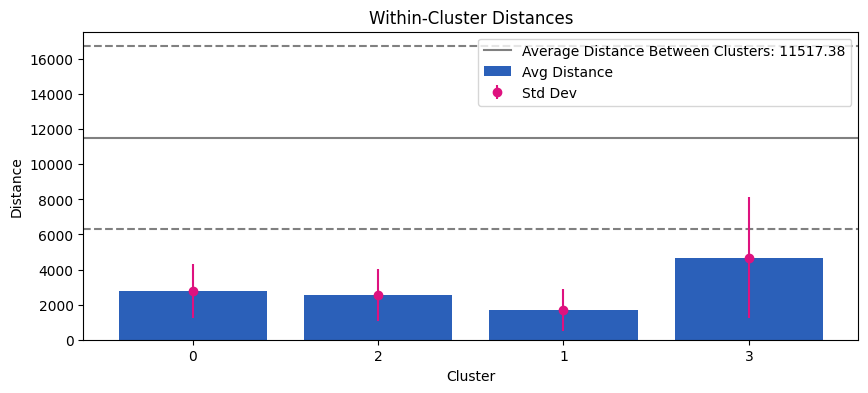

In [46]:
# Plot within-cluster distances
plt.figure(figsize=(10, 4))
sns.barplot(data=within_cluster_df, x='Cluster', y='Avg Distance Within', color='#145ad0', label='Avg Distance')
plt.errorbar(x=within_cluster_df['Cluster'], 
             y=within_cluster_df['Avg Distance Within'], 
             yerr=within_cluster_df['Std Distance Within'], 
             fmt='o', color='#de127f', label='Std Dev')
plt.title('Within-Cluster Distances')
plt.xlabel('Cluster')
plt.ylabel('Distance')



plt.axhline(avg_distance_between_clusters, c='grey', linestyle='-', label=f'Average Distance Between Clusters: {avg_distance_between_clusters:.2f}')
plt.axhline(avg_distance_between_clusters+std_distance_between_clusters, c='grey', linestyle='--', zorder=0)
plt.axhline(avg_distance_between_clusters-std_distance_between_clusters, c='grey', linestyle='--', zorder=0)

plt.legend(loc='upper right')
plt.show()

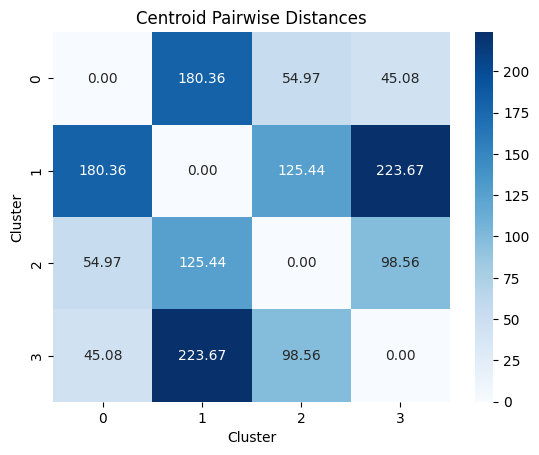

In [31]:
# Plot heatmap for centroid distances
# plt.figure(figsize=(8, 6))
sns.heatmap(centroid_distances, annot=True, fmt='.2f', cmap='Blues', xticklabels=centroids.index, yticklabels=centroids.index)
plt.title('Centroid Pairwise Distances')
plt.xlabel('Cluster')
plt.ylabel('Cluster')

plt.show()

### Clusters Behaviors

In [47]:
df_customer_abt[cluster_col] = pd.to_numeric(df_customer_abt[cluster_col], errors='coerce')

# Create a parallel coordinates plot using Plotly
fig = px.parallel_coordinates(
    df_customer_abt,
    dimensions=['total_products', 'avg_produtcs_per_purchase', 'avg_profit', 'avg_discount'],
    color=cluster_col,
    color_continuous_scale=px.colors.sequential.Agsunset_r,
)

# Update layout for a clean design
fig.update_layout(
    title='Parallel Coordinates Plot for Customer Segmentation',
    title_x=0.5,  # Center title
    title_y=0.99,  # Move title upwards (default is 1.0)
    font=dict(size=12),
    plot_bgcolor="white"
)

# Show the plot
fig.show()

In [55]:
cols_to_chart = ['total_products', 'avg_produtcs_per_purchase', 'avg_profit', 'avg_discount']
# Get the unique clusters
clusters = df_customer_abt['cluster'].unique()

# Create the radar chart
fig = go.Figure()

# Loop through each cluster and add a trace
for cluster in clusters:
    cluster_data = df_customer_abt[df_customer_abt['cluster'] == cluster]
    
    # Calculate the mean for each feature in the cluster
    mean_values = cluster_data[cols_to_chart].mean()
    
    # Add the trace for this cluster
    fig.add_trace(go.Scatterpolar(
        r=mean_values.values,  # Values for each axis
        theta=mean_values.index,  # Feature names
        fill='toself',  # Fill the area under the line
        name=f'{cluster}',  # Name for the trace
        line=dict(color=px.colors.qualitative.Set2[int(cluster) % len(px.colors.qualitative.Set2)])  # Use a discrete color for each cluster
    ))

# Update layout for a clean design
fig.update_layout(
    title='Radar Chart for Customer Segmentation by Cluster',
    title_x=0.5,  # Center title
    polar=dict(
        radialaxis=dict(range=[0, df_customer_abt[cols_to_chart].quantile(0.95).max()]),  # Set the range of the radial axis
    ),
    font=dict(size=12),
    plot_bgcolor="white"
)

# Show the plot
fig.show()

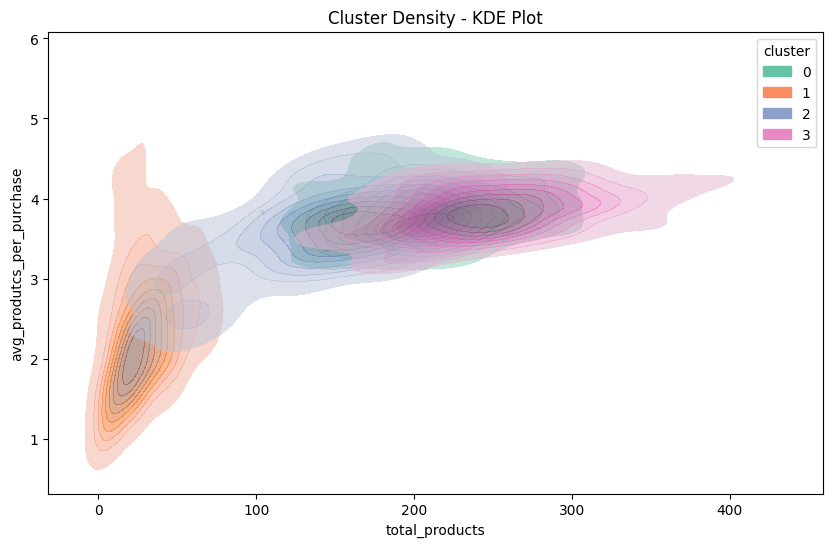

In [56]:
# Plot KDE for each cluster
plt.figure(figsize=(10, 6))

sns.kdeplot(
    data=df_customer_abt,
    x='total_products',
    y='avg_produtcs_per_purchase',
    hue=cluster_col,
    fill=True,  # Fill the area under the curve
    common_norm=False,  # Normalize separately for each cluster
    palette='Set2'  # Color palette for the clusters
    , alpha=0.5
)

plt.title('Cluster Density - KDE Plot')
# plt.xlabel('Total Products')
# plt.ylabel('Avg Products per Purchase')
plt.show()

### In Depth Analysis

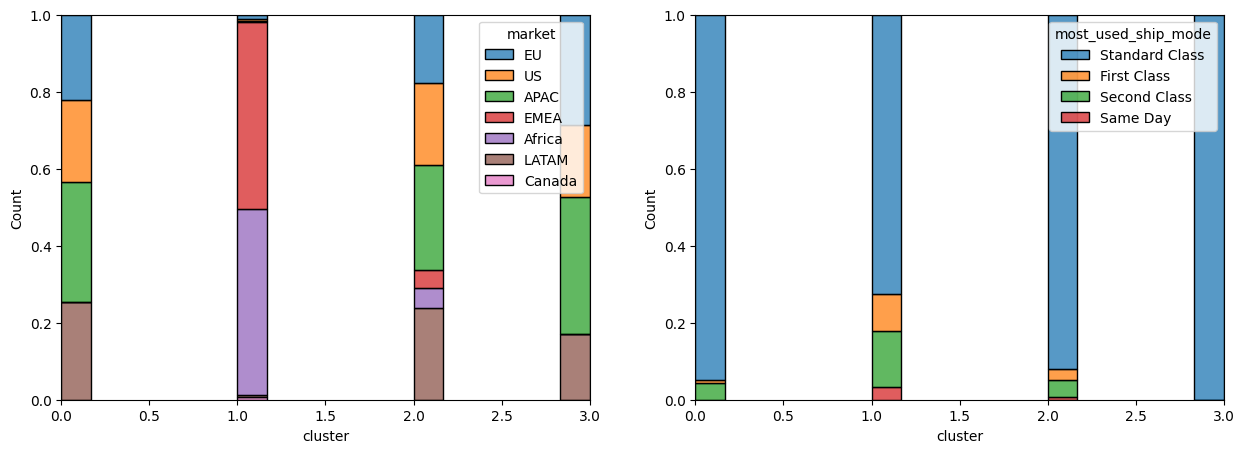

In [57]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(data=df_customer_abt, x=cluster_col, hue='market', multiple='fill', shrink=1)
plt.subplot(1,2,2)
sns.histplot(data=df_customer_abt, x=cluster_col, hue='most_used_ship_mode', multiple='fill', shrink=1)
plt.show()

No PLot because of Unique Values for 'Customer ID' = 1583


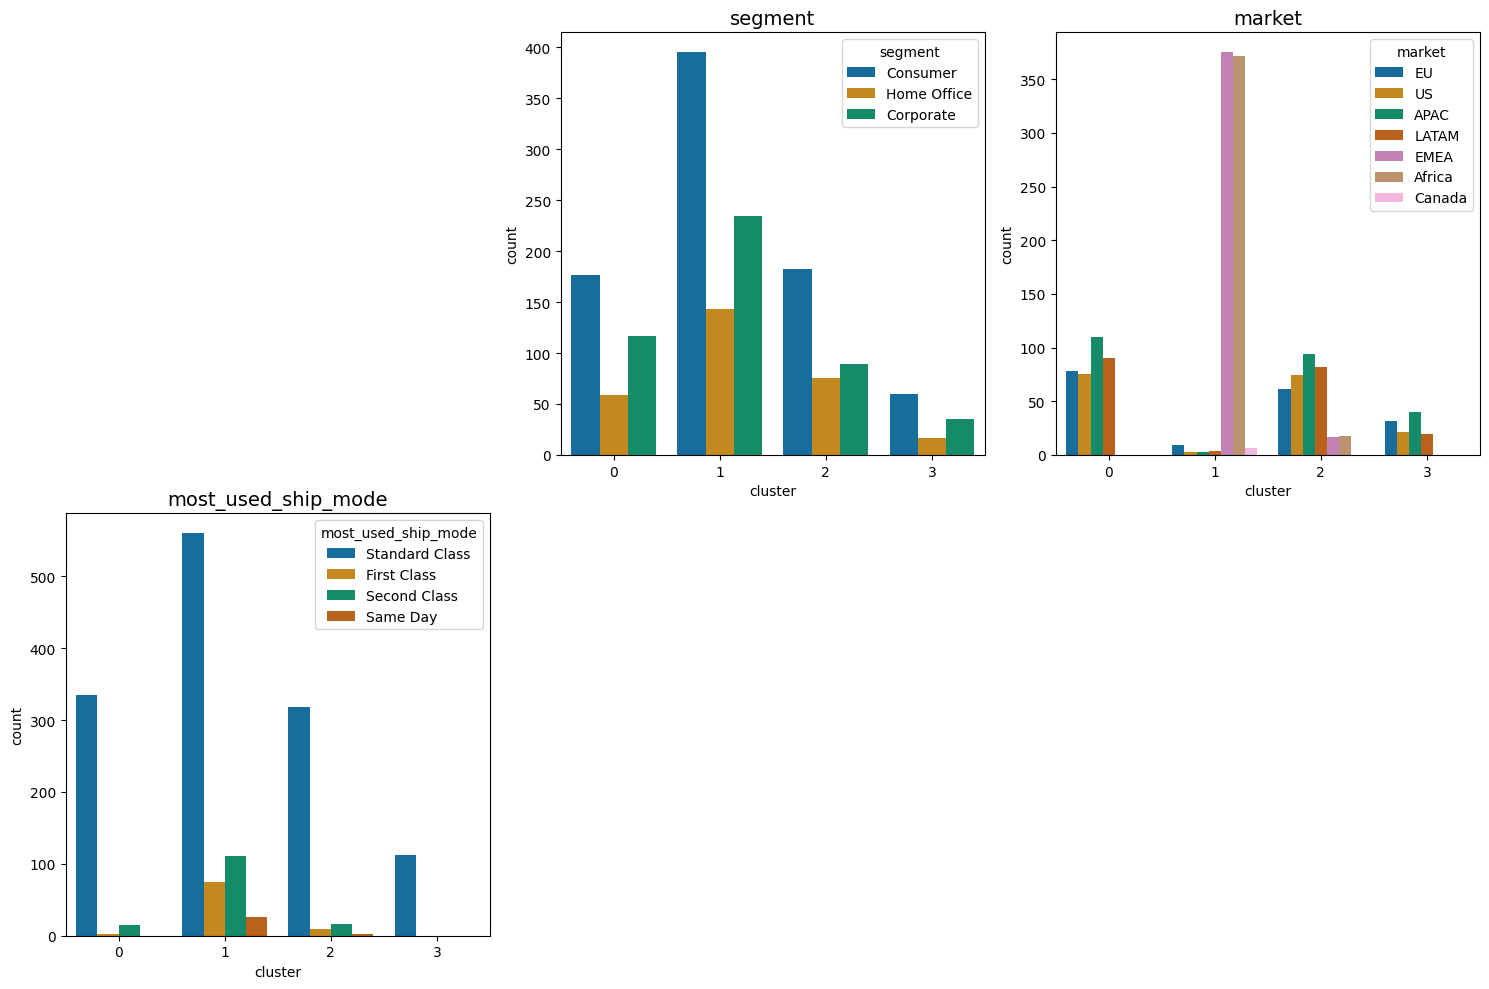

CPU times: total: 172 ms
Wall time: 678 ms


In [64]:
%%time 
# Set up the plotting area for individual subplots
num_columns = 3
num_categories = len(categories)  # Use categories instead of features
num_rows = (num_categories + num_columns - 1) // num_columns

# Set the figure size
plt.figure(figsize=(15, num_rows * 5))

# Loop through each category and create a count plot
for i, category in enumerate(categories):
    if df_customer_abt[category].nunique() <= 10:
        plt.subplot(num_rows, num_columns, i + 1)
        sns.countplot(data=df_customer_abt, x='cluster', hue=category, palette='colorblind')
        plt.title(f"{category}", fontsize=14)
    else:
        print(f"No PLot because of Unique Values for '{category}' = {df_customer_abt[category].nunique()}")
plt.tight_layout()
plt.show()

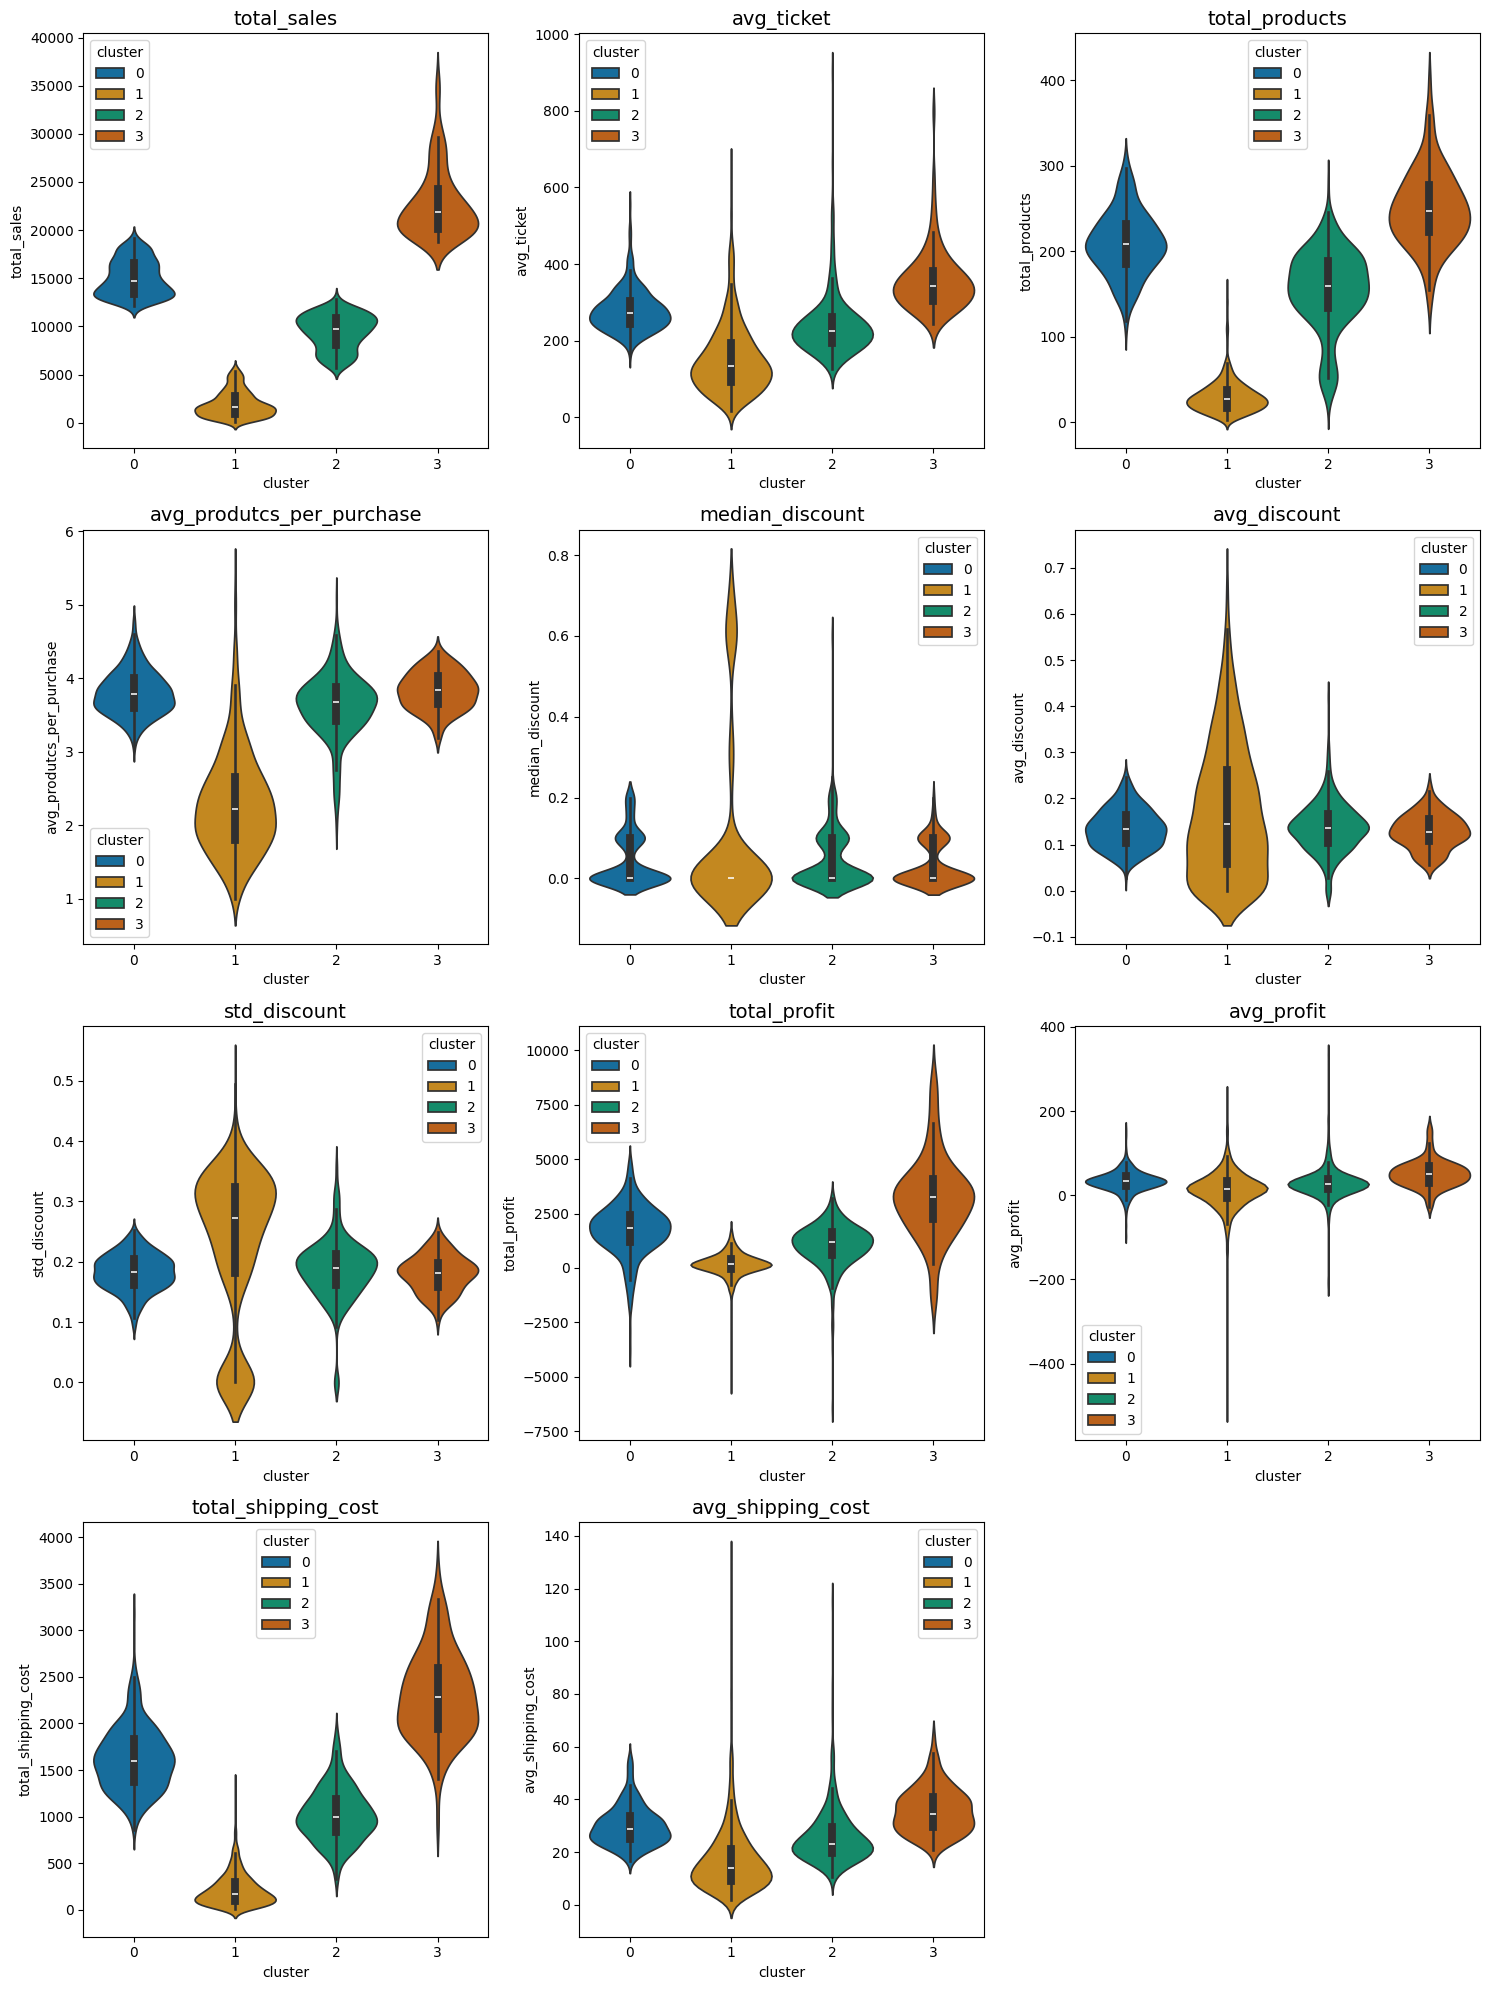

In [65]:
# Set up the plotting area for individual subplots
num_columns = 3
num_features = len(features)
num_rows = (num_features + num_columns - 1) // num_columns

plt.figure(figsize=(15, num_rows * 5))

for i, feature in enumerate(features):
    plt.subplot(num_rows, num_columns, i + 1)
    sns.violinplot(data=df_customer_abt, x='cluster', y=feature, hue='cluster', palette='colorblind')
    plt.title(f"{feature}", fontsize=14)

plt.tight_layout()
plt.show()

In [67]:
features_lim = features

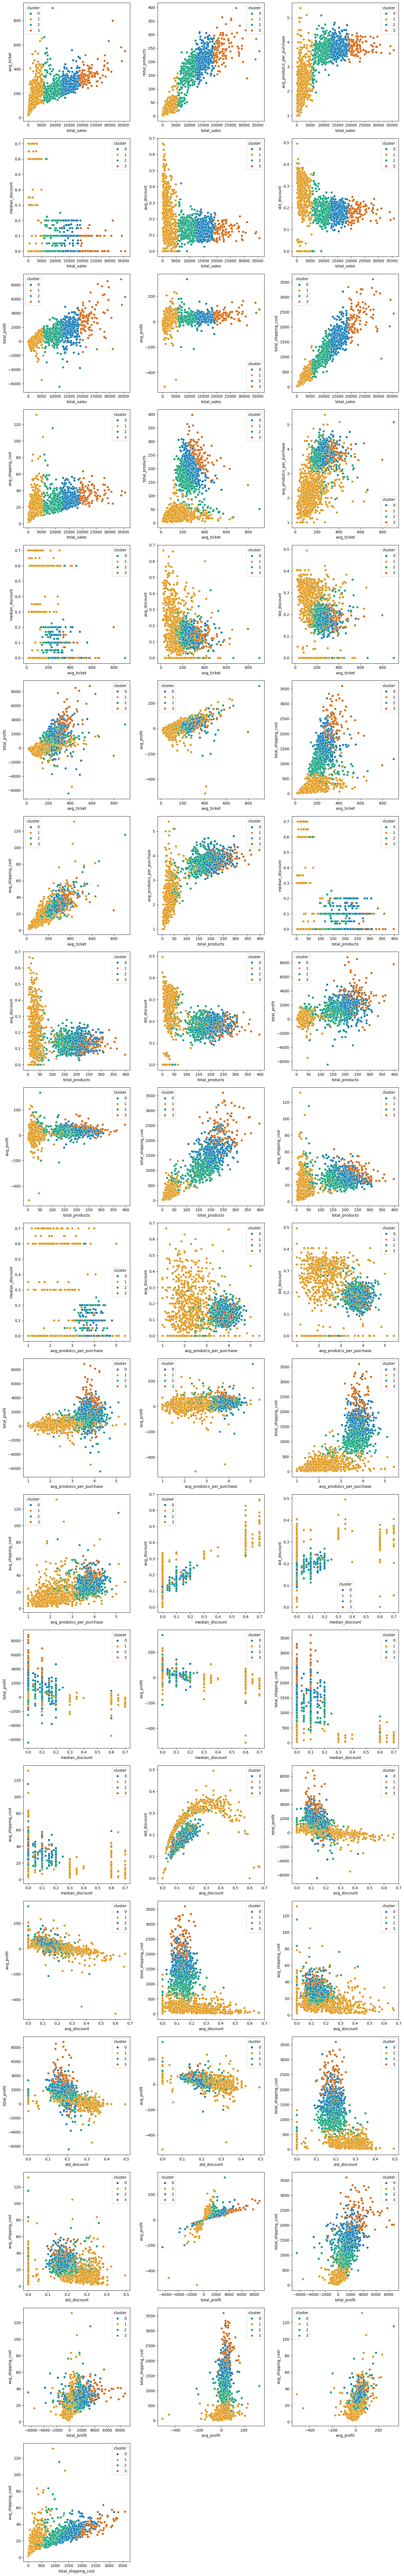

CPU times: total: 2.48 s
Wall time: 10.3 s


In [68]:
%%time
category = 'cluster'

# Number of columns for the subplot grid
num_columns = 3
num_rows = (len(features_lim) * (len(features_lim) - 1) // 2 + num_columns - 1) // num_columns  # Calculate the number of rows needed

# Set up the figure size
plt.figure(figsize=(15, num_rows * 5))

# Create a scatter plot for each pair of features
plot_index = 1
for i in range(len(features_lim)):
    for j in range(i + 1, len(features_lim)):
        plt.subplot(num_rows, num_columns, plot_index)
        sns.scatterplot(data=df_customer_abt, x=features_lim[i], y=features_lim[j], hue=category, palette='colorblind')
        # plt.title(f'{features_lim[i]} vs. {features_lim[j]}')
        plt.xlabel(features_lim[i])
        plt.ylabel(features_lim[j])
        plot_index += 1

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()

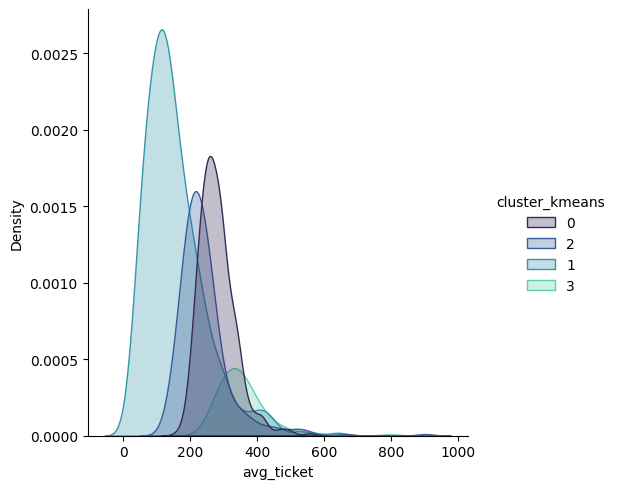

In [76]:
# sns.histplot(df_customer_abt, x='avg_ticket', hue=cluster_col, element='step', palette='mako')
sns.displot(df_customer_abt, x='avg_ticket', hue=cluster_col, kind='kde', fill=True, alpha=0.3, palette='mako')

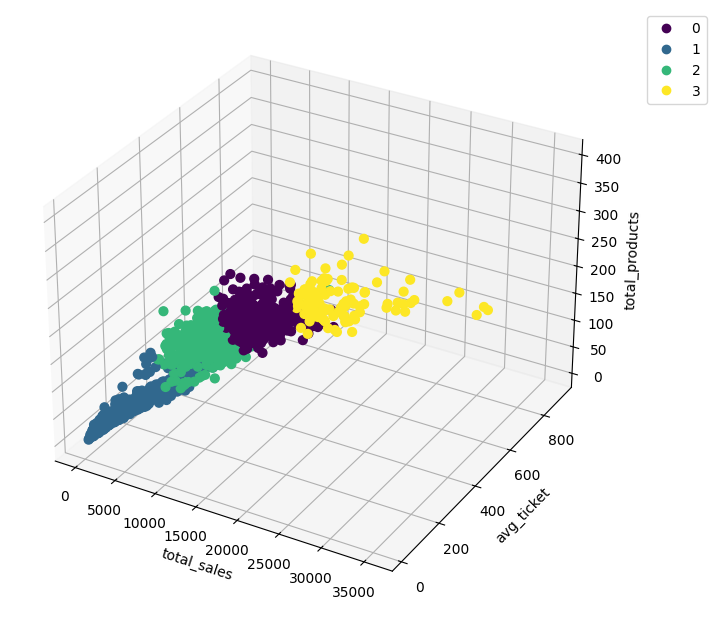

In [34]:
df_temp = df_customer_abt.copy()#[df_customer_abt['value'] < customer_abt['value'].quantile(.95)]

variables = ['total_sales', 'avg_ticket', 'total_products']

x = df_temp[variables[0]]
y = df_temp[variables[1]]
z = df_temp[variables[2]]
# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)


# plot
sc = ax.scatter(x, y, z, s=40, c=df_temp['cluster'], marker='o', alpha=1)
ax.set_xlabel(variables[0])
ax.set_ylabel(variables[1])
ax.set_zlabel(variables[2])

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.show()

### Cluster Profiles

In [97]:
analysis_cols = features

In [98]:
df_customer_abt[analysis_cols+[cluster_col]].groupby([cluster_col]).describe()

total_sales                                          \
                     count          mean          std          min   
cluster_kmeans                                                       
0                    353.0  15031.495150  1864.980623  12108.30958   
1                    772.0   1954.284485  1344.910359     52.04700   
2                    346.0   9470.851254  1795.434728   5689.26300   
3                    112.0  22768.126485  3610.637266  18725.38964   

                                                                   avg_ticket  \
                        25%          50%          75%          max      count   
cluster_kmeans                                                                  
0               13405.60130  14689.34250  16552.06996  19218.81298      353.0   
1                 926.87475   1649.36400   2733.62250   5765.40000      772.0   
2                8092.03055   9752.26435  10900.27161  12864.72050      346.0   
3               20131.31960  21901.46072  24232.17385  35668.12080      112.0   

                                                                           \
                      mean        std         min         25%         50%   
cluster_kmeans                                                              
0               279.718885  54.387180  164.159131  242.192232  271.492877   
1               153.934345  91.587364   17.349000   90.848711  133.405750   
2               241.157400  81.595902  126.626785  194.627735  225.459635   
3               356.826385  80.184233  244.615402  304.414676  342.398917   

                                       total_products                         \
                       75%         max          count        mean        std   
cluster_kmeans                                                                 
0               304.805378  556.082428          353.0  209.104816  37.387525   
1               194.548667  653.639250          772.0   29.873057  19.393915   
2               262.463022  902.748000          346.0  154.312139  46.485163   
3               382.906338  798.084486          112.0  250.151786  44.745972   

                                                   avg_produtcs_per_purchase  \
                  min    25%    50%     75%    max                     count   
cluster_kmeans                                                                 
0               108.0  185.0  208.0  232.00  309.0                     353.0   
1                 2.0   17.0   27.0   38.00  157.0                     772.0   
2                21.0  133.0  159.0  188.00  278.0                     346.0   
3               139.0  222.0  247.5  277.25  398.0                     112.0   

                                                                            \
                    mean       std       min       25%       50%       75%   
cluster_kmeans                                                               
0               3.802518  0.298822  3.051724  3.589286  3.779661  4.000000   
1               2.288957  0.691010  1.000000  1.800000  2.214286  2.657051   
2               3.627949  0.434828  1.947368  3.415627  3.677460  3.883798   
3               3.831195  0.257446  3.189655  3.644004  3.838562  4.032923   

                         median_discount                                     \
                     max           count      mean       std  min  25%  50%   
cluster_kmeans                                                                
0               4.803279           353.0  0.045487  0.064077  0.0  0.0  0.0   
1               5.400000           772.0  0.101860  0.219884  0.0  0.0  0.0   
2               5.100000           346.0  0.047971  0.075439  0.0  0.0  0.0   
3               4.367647           112.0  0.034563  0.051734  0.0  0.0  0.0   

                         avg_discount                                          \
                75%  max        count      mean       std       min       25%   
cluster_kmeans                 

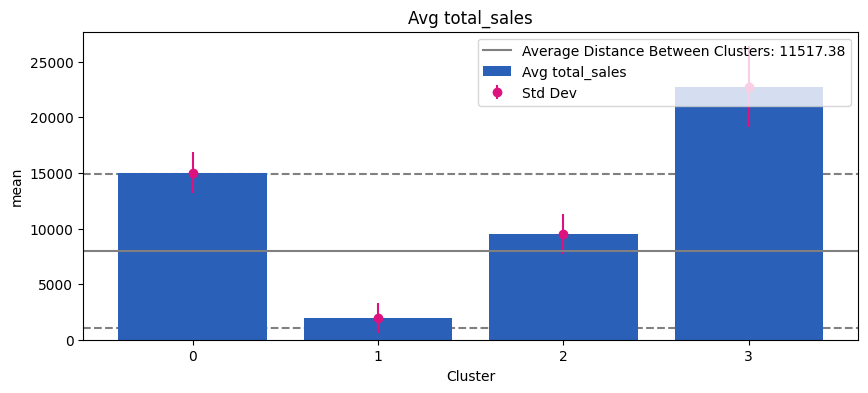

In [70]:
variable = features[0]
df_groupby_cluster = df_customer_abt.groupby(['cluster'])[variable].describe().reset_index()
df_desc_all = df_customer_abt[[variable]].describe().T

plt.figure(figsize=(10, 4))
sns.barplot(data=df_groupby_cluster, x='cluster', y='mean', color='#145ad0', label=f'Avg {variable}')
plt.errorbar(x=df_groupby_cluster['cluster'], 
             y=df_groupby_cluster['mean'], 
             yerr=df_groupby_cluster['std'], 
             fmt='o', color='#de127f', label='Std Dev')
plt.title(f'Avg {variable}')
plt.xlabel('Cluster')
# plt.ylabel(f'Avg {variable}')



plt.axhline(df_desc_all['mean'].values, c='grey', linestyle='-', label=f'Average Distance Between Clusters: {avg_distance_between_clusters:.2f}')
plt.axhline((df_desc_all['mean']+df_desc_all['std']).values, c='grey', linestyle='--', zorder=0)
plt.axhline((df_desc_all['mean']-df_desc_all['std']).values, c='grey', linestyle='--', zorder=0)

plt.legend(loc='upper right')
plt.show()

In [78]:
df_customer_abt[['avg_profit', 'avg_produtcs_per_purchase', 'avg_ticket', 'avg_discount', 'avg_shipping_cost']+[cluster_col]].groupby([cluster_col]).describe().T

cluster_kmeans                            0           1           2  \
avg_profit                count  353.000000  772.000000  346.000000   
                          mean    32.953438   12.835755   28.584605   
                          std     25.382956   49.781004   38.288575   
                          min    -97.181617 -511.770000 -214.578937   
                          25%     21.516478   -7.243400   13.687291   
                          50%     33.714463   15.219727   26.760595   
                          75%     44.605409   33.440332   39.495716   
                          max    157.718306  232.661143  334.134000   
avg_produtcs_per_purchase count  353.000000  772.000000  346.000000   
                          mean     3.802518    2.288957    3.627949   
                          std      0.298822    0.691010    0.434828   
                          min      3.051724    1.000000    1.947368   
                          25%      3.589286    1.800000    3.415627   
                          50%      3.779661    2.214286    3.677460   
                          75%      4.000000    2.657051    3.883798   
                          max      4.803279    5.400000    5.100000   
avg_ticket                count  353.000000  772.000000  346.000000   
                          mean   279.718885  153.934345  241.157400   
                          std     54.387180   91.587364   81.595902   
                          min    164.159131   17.349000  126.626785   
                          25%    242.192232   90.848711  194.627735   
                          50%    271.492877  133.405750  225.459635   
                          75%    304.805378  194.548667  262.463022   
                          max    556.082428  653.639250  902.748000   
avg_discount              count  353.000000  772.000000  346.000000   
                          mean     0.135272    0.172308    0.137548   
                          std      0.042905    0.142056    0.053224   
                          min      0.027841    0.000000    0.000000   
                          25%      0.102326    0.058333    0.103245   
                          50%      0.133036    0.145299    0.136739   
                          75%      0.164444    0.262500    0.166452   
                          max      0.258258    0.666667    0.420000   
avg_shipping_cost         count  353.000000  772.000000  346.000000   
                          mean    30.156771   17.056846   26.041664   
                          std      7.552972   12.502609   10.891646   
                          min     16.677258    1.646667   10.617143   
                          25%     24.829667    8.975028   19.475156   
                          50%     28.940385   13.949000   23.191193   
                          75%     33.835769   21.267589   29.490237   
                          max     56.504828  131.441429  115.358000   

cluster_kmeans                            3  
avg_profit                count  112.000000  
                          mean    51.601363  
                          std     32.623270  
                          min    -27.786522  
                          25%     30.234919  
                          50%     49.387303  
                          75%     69.331613  
                          max    162.925570  
avg_produtcs_per_purchase count  112.000000  
                          mean     3.831195  
                          std      0.257446  
                          min      3.189655  
                          25%      3.644004  
                          50%      3.838562  
                          75%      4.032923  
                          max      4.367647  
avg_ticket                count  112.000000  
                          mean   356.826385  
                          std     80.184233  
                          min    244.615402  
                          25%    304.414676  
                          50%    342.398917  
                          75% 

### Customer Profiles/Business Opportunity Map

Description for each cluster based on their most relevant characteristics (both statisticaly and at a business level).    

        GPT can help you with this: I Am working on a data science project (customer segmentation) and I need you to analyze these statistics and do these:
        1. Give to each of these clusters a business name and a business description/profile.
        2. Tell me their most relevant statistics
        3. And tell me what business strategies the company can use to approach these customers and make more money.

_Here's a Template._    

Cluster 0: **Cluster Name**

**Profile/Description:** BUSINESS_DESCRIPTION   



**Relevant Statistics:**

- **VARIABLE_NAME (FEATURE_NAME)**

- Mean: 
- Median: 
- Standard Deviation: 
- Min: 
- Max: 

**Business Strategy:**

- **STRATEGY_1:** STRATEGIC_PLAN_OF_ACTION
- **STRATEGY_2:** STRATEGIC_PLAN_OF_ACTION
- **STRATEGY_2:** STRATEGIC_PLAN_OF_ACTION


| Cluster Name         | Feature A | Feature B | Feature C | Strategic Approach                                                    |
|-----------------------|------------|------------|-----------------------|------------------------------------------------------------------------|
| **Cluster Name** | VALUE       | VALUE       | VALUE              | Strategy.            |

### Business Descriptions

_Example._


**Cluster 0: "Premium Shoppers"** 

- **Business Description:**
    
    High-value customers who prioritize quality and convenience. They consistently purchase multiple products per transaction and are willing to spend more on average. They appreciate thoughtful service and added value but show moderate responsiveness to discounts.

- **Key Attributes:**

    Loyal and profitable.
    Frequently purchase high-ticket items.
    Moderate price sensitivity.

- **Business Objective:**
    
    Retain and grow this segment by enhancing customer loyalty and maintaining their premium experience.

**Cluster 1: "Bargain Hunters"**

- **Business Description:**

    Customers who focus on finding the best deals and minimizing expenses. They typically make smaller transactions and are highly responsive to discounts and promotions. They avoid spending on shipping or additional costs.

- **Key Attributes:**

    Price-sensitive and deal-driven.
    Contribute to volume over profit.
    High potential for conversion with targeted promotions.

- **Business Objective:**

    Increase transaction size and frequency by offering value bundles and targeted discounts without compromising margins.

**Cluster 2: "Consistent Buyers"**

- **Business Description:**

    Stable customers with predictable buying patterns. They make moderately priced transactions and purchase multiple products per order. They value consistency and trust in the company, responding well to modest incentives.

- **Key Attributes:**

    Reliable revenue stream.
    Moderate profit contribution.
    Loyal with steady growth potential.

- **Business Objective:**

    Strengthen relationships by fostering loyalty, offering upselling opportunities, and maintaining their satisfaction with consistent service quality.

**Cluster 3: "Luxury Enthusiasts"**

- **Business Description:

    Elite customers who gravitate toward high-end products and premium services. They make the highest-value transactions and exhibit low sensitivity to discounts. They are willing to pay for exceptional shipping and personalized offerings.

- **Key Attributes:**

    Significant profit contributors.
    Seek exclusivity and quality.
    Low price sensitivity.

- **Business Objective:**
    
    Maximize lifetime value by delivering bespoke experiences, offering exclusive access to luxury items, and ensuring premium service quality.



#### Strategic Alignment with Business Goals

1. Revenue Growth:

    Focus on Premium Shoppers and Luxury Enthusiasts to maximize profits. Develop tailored offers for Bargain Hunters to increase sales volume.

2. Customer Retention:

    Strengthen loyalty for Consistent Buyers and Premium Shoppers with targeted loyalty programs.

3. Brand Positioning:

    Emphasize premium quality and exclusivity for Luxury Enthusiasts while maintaining affordability for Bargain Hunters.

4. Operational Efficiency:

    Optimize shipping and pricing strategies to balance the needs of Bargain Hunters and Luxury Enthusiasts without compromising profit margins.

In [ ]:
"If data is scaled You May Need to Create a New Notebook (save the id, cluster) to generate visuals based on the business scale/metrics."